In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Lasso
import warnings
import seaborn as sns
from scipy.optimize import minimize
import copy

<h1>Hyperparameters<h1>


In [212]:
K = 5 # validation folds
MIN_LAG = 120
MAX_LAG = 168
SEED = 42
VAL_SPLIT = 0.15

In [213]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

<h1>Creating DataFrames<h1>

In [214]:
spot_prices = pd.read_csv("spotpriser.csv").set_index("time")
consumption = pd.read_csv("consumption_temp_with_flags.csv").set_index("time")

oslo_consumption = consumption[consumption["location"] == "oslo"]
oslo_consumption = oslo_consumption.merge(spot_prices["oslo"], left_index=True, right_index=True, how="left")
oslo_consumption=oslo_consumption.drop(['location'],axis=1).rename(columns={'oslo':'spot_price'})

stavanger_consumption = consumption[consumption["location"] == "stavanger"]
stavanger_consumption = stavanger_consumption.merge(spot_prices["stavanger"], left_index=True, right_index=True, how="left")
stavanger_consumption=stavanger_consumption.drop(['location'],axis=1).rename(columns={'stavanger':'spot_price'})

trondheim_consumption = consumption[consumption["location"] == "trondheim"]
trondheim_consumption = trondheim_consumption.merge(spot_prices["trondheim"], left_index=True, right_index=True, how="left")
trondheim_consumption=trondheim_consumption.drop(['location'],axis=1).rename(columns={'trondheim':'spot_price'})

tromso_consumption = consumption[consumption["location"] == "tromsø"]
tromso_consumption = tromso_consumption.merge(spot_prices["tromsø"], left_index=True, right_index=True, how="left")
tromso_consumption=tromso_consumption.drop(['location'],axis=1).rename(columns={'tromsø':'spot_price'})

bergen_consumption = consumption[consumption["location"] == "bergen"]
bergen_consumption = bergen_consumption.merge(spot_prices["bergen"], left_index=True, right_index=True, how="left")
bergen_consumption=bergen_consumption.drop(['location'],axis=1).rename(columns={'bergen':'spot_price'})
    

<h1>Feature engineering<h1>

In [215]:
DFS = [oslo_consumption,stavanger_consumption,trondheim_consumption,tromso_consumption,bergen_consumption]
DFS_orig = copy.deepcopy(DFS)
DF_STRINGS = ["Oslo","Stavanger","Trondheim","Tromsø","Bergen"]

cols_to_standard_normal = ["temperature","consumption"]
cols_to_normalize_01 = ["consumption","spot_price"]
columns_to_decompose = ['temperature', 'spot_price','consumption']
cols_to_diff = []
REVERSE_CONSUMPTION_NORMALIZATION = [] #note: Same order as consumption_dfs
for i in range(len(DFS)):
    DFS[i].index = pd.to_datetime(DFS[i].index)
DFS_orig = copy.deepcopy(DFS)

In [216]:
def lag_columns(df, min_lag,max_lag, columns):
    for col in columns:
        if col in df.columns:
            for lag in range(min_lag,max_lag+1):
                df[f"{col}_L{lag}"] =  df[col].shift(lag)
            if col not in ['consumption_seasonal', 'consumption_trend']:
                df.drop(col, axis=1) 
    return df.dropna(axis=0)


def decompose_time_series(df, columns_to_decompose=columns_to_decompose, period=24):
    for col in columns_to_decompose:
        if col in df.columns:
            # Decompose the time series
            result = seasonal_decompose(df[col], model='additive', period=period)

            # Create new columns for trend and seasonal components
            df[f"{col}_trend"] = result.trend
            df[f"{col}_seasonal"] = result.seasonal

            # Drop the original column
            df.drop(col, axis=1, inplace=True)
        else:
            print(f"Column '{col}' not found in DataFrame.")
    
    return df

def add_interaction_column(df,col1, col2):
    df[f"{col1}_X_{col2}"] = df[col1]*df[col2]
    return df.dropna() 

In [217]:
for i in range(len(DFS)):
    DFS[i].dropna(axis=0, inplace=True)
    DFS[i]["is_holiday"] = DFS[i]["is_holiday"].astype(int)
    DFS[i]["is_weekend"] = DFS[i]["is_weekend"].astype(int)
    
    DFS[i]["hour"] = np.cos(DFS[i].index.hour*np.pi/12)
    DFS[i]["month"] = np.cos(DFS[i].index.month*np.pi/6)

    for col in cols_to_standard_normal:
        mu, sig = DFS[i][col].mean(), DFS[i][col].std()
        if col == "consumption":
            REVERSE_CONSUMPTION_NORMALIZATION.append([mu,sig])
        DFS[i][col] = (DFS[i][col]-mu)/sig
    for col in cols_to_normalize_01:
        DFS[i][col] = (DFS[i][col]-DFS[i][col].min())/(DFS[i][col].max()-DFS[i][col].min())
    DFS[i] = decompose_time_series(DFS[i])
    DFS[i] = lag_columns(DFS[i], min_lag=24,max_lag = MAX_LAG, columns=["temperature_trend", "temperature_seasonal", "spot_price_trend", "spot_price_seasonal"])
    DFS[i] = lag_columns(DFS[i], min_lag=MIN_LAG,max_lag = MAX_LAG, columns=["consumption_trend","consumption_seasonal"])
    DFS[i] = add_interaction_column(DFS[i], "hour", "is_weekend")
    DFS[i] = add_interaction_column(DFS[i], "month", "is_weekend")
    DFS[i] = add_interaction_column(DFS[i], "hour", "is_holiday")
    DFS[i] = add_interaction_column(DFS[i], "month", "is_holiday")
    DFS[i] = DFS[i].dropna(axis=0)


/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_91242/1014637254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_L{lag}"] =  df[col].shift(lag)
/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_91242/1014637254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_L{lag}"] =  df[col].shift(lag)
/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_91242/1014637254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

<h1>Training<h1>

In [218]:
# k-Fold for validation
k = K
np.random.seed(SEED)


def avoid_spillover_split(X,offset):
    length = len(X)
    indices = np.arange(offset, length+1, MAX_LAG+1)
    return X.iloc[indices]

def custom_train_val_split(data, val_split):
    thresh = np.floor(len(data) * (1 - val_split)).astype(int)
    return data.iloc[:thresh], data.iloc[thresh:]

In [219]:
eps = 2**(-30)

def soft_abs(z):
    return np.sqrt(z**2+eps)

In [220]:

def cross_validate(data,alpha1,alpha2,mu,sig,MAPEfac,initVarianceFac):
    # Lasso with MAPE Loss
    def lasso_mape_loss(w, X, y_true, alpha):
    
        y_pred = X @ w
        return np.mean(soft_abs((y_true - y_pred)/(y_true+MAPEfac))) + alpha * np.sum(soft_abs(w))/np.mean(y_true+MAPEfac)
    mape_values = []
    L = len(data)
    offsets = range(1,L,int(np.floor(L/k)))
    for offset in offsets:
        X = data.iloc[offset:int(offset + np.floor(L/k))]
        y1 = X["consumption_seasonal"]
        y2 = X["consumption_trend"]
        X = X.drop(columns = ["consumption_seasonal","consumption_trend"])
        X_train, X_val = custom_train_val_split(X, VAL_SPLIT)
        y1_train, y1_val = custom_train_val_split(y1, VAL_SPLIT)
        y2_train, y2_val = custom_train_val_split(y2, VAL_SPLIT)
        
        tol = 1e-4
        n_features = X_train.shape[1]
        w_optimal_1 = np.random.randn(n_features)/initVarianceFac # Random initialize
        w_optimal_2 = np.random.randn(n_features)/initVarianceFac # Random initialize
        for i in range(2):
            w_initial1 = np.where(w_optimal_1>10**(-2),w_optimal_1,0)+np.random.randn(n_features)/1000 # Set small coefficients to zero, add noise 
            w_initial2 = np.where(w_optimal_2>10**(-2),w_optimal_2,0)+np.random.randn(n_features)/1000 # Set small coefficients to zero, add noise 
            result = minimize(lasso_mape_loss, w_initial1, args=(X_train, y1_train, alpha1), method='L-BFGS-B', options={'tol':tol})
            w_optimal_1 = result.x
            result = minimize(lasso_mape_loss, w_initial2, args=(X_train, y2_train, alpha2), method='L-BFGS-B', options={'tol':tol})
            w_optimal_2 = result.x

        y1_pred = X_val @ w_optimal_1
        y2_pred = X_val @ w_optimal_2

        mape = np.mean(np.abs(((y1_val+y2_val)*sig - (y1_pred+y2_pred)*sig) / ((y1_val+y2_val)*sig+mu))) * 100
        mape_values.append(mape)
    average_mape = np.mean(mape_values)
    return average_mape

Oslo
Alpha1, alpha2, MAPEfac, initVarianceFac --> MAPE
3.814697265625e-06 0.0009765625 10 50 --> 1.7288487704401097
3.814697265625e-06 0.0009765625 10 75 --> 1.3109381536434226
3.814697265625e-06 0.00390625 10 50 --> 1.5305853150122841
3.814697265625e-06 0.00390625 10 75 --> 1.172735706892937
1.52587890625e-05 0.0009765625 10 50 --> 1.4829416404290678
1.52587890625e-05 0.0009765625 10 75 --> 1.1068065902260327
1.52587890625e-05 0.00390625 10 50 --> 1.4391795282952997
1.52587890625e-05 0.00390625 10 75 --> 1.011526858327446
Best Hyperparameters: (1.52587890625e-05, 0.00390625, 10, 75)
Best CV MAPE: 1.011526858327446%


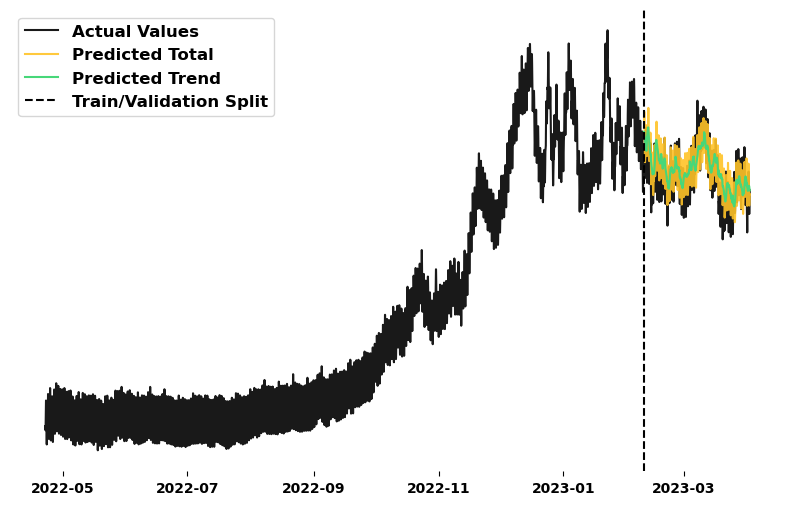

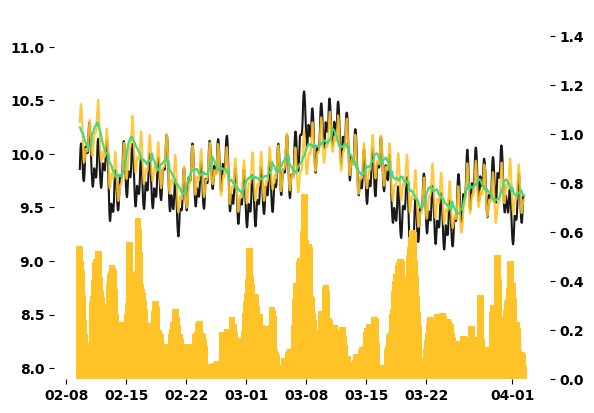

Error95: 0.033213975240661
Out of sample MAPE: 1.418069422426286
Mean oveprediction: 1.648055253465936
Mean underprediction: 0.9893631152579061
MAPE with trend prediction only: 2.020485727921317
Coefficients: 
is_holiday: 0.05960183174631412
is_weekend: 0.06259177062888223
hour: 0.003214542799720086
month: 0.0335541068773457
temperature_trend: -0.16256834842933843
temperature_seasonal: 0.054679887719640385
spot_price_trend: -0.003804595069492057
spot_price_seasonal: 0.09317173112027763
temperature_trend_L24: -0.060204902121780625
temperature_trend_L25: -0.053801671174651976
temperature_trend_L26: -0.0476253181862412
temperature_trend_L27: -0.04172236997184657
temperature_trend_L28: -0.036115233360666466
temperature_trend_L29: -0.03081526283797466
temperature_trend_L30: -0.02584008562692499
temperature_trend_L31: -0.021217386162588118
temperature_trend_L32: -0.016979017157262664
temperature_trend_L33: -0.013146034253659403
temperature_trend_L34: -0.009716583323436268
temperature_trend_L

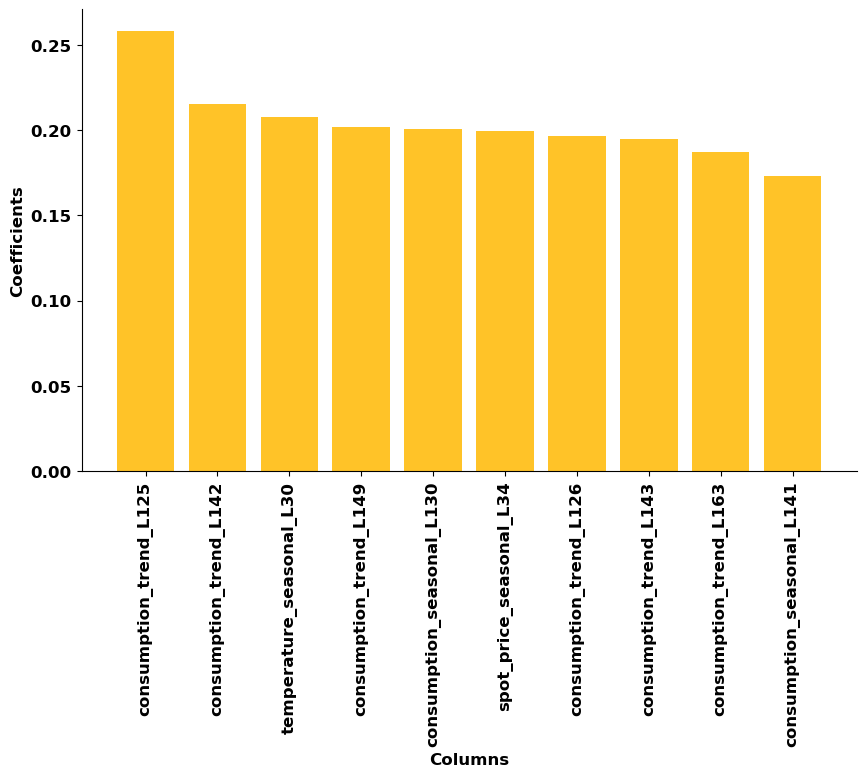

Stavanger
Alpha1, alpha2, MAPEfac, initVarianceFac --> MAPE
3.814697265625e-06 0.0009765625 10 50 --> 1.8335064701920811
3.814697265625e-06 0.0009765625 10 75 --> 1.7549536385857423
3.814697265625e-06 0.00390625 10 50 --> 1.943724674445003
3.814697265625e-06 0.00390625 10 75 --> 1.538195094980957
1.52587890625e-05 0.0009765625 10 50 --> 1.6780855675385282
1.52587890625e-05 0.0009765625 10 75 --> 1.8260876553483036
1.52587890625e-05 0.00390625 10 50 --> 1.669223084840754
1.52587890625e-05 0.00390625 10 75 --> 1.6866244853214312
Best Hyperparameters: (3.814697265625e-06, 0.00390625, 10, 75)
Best CV MAPE: 1.538195094980957%


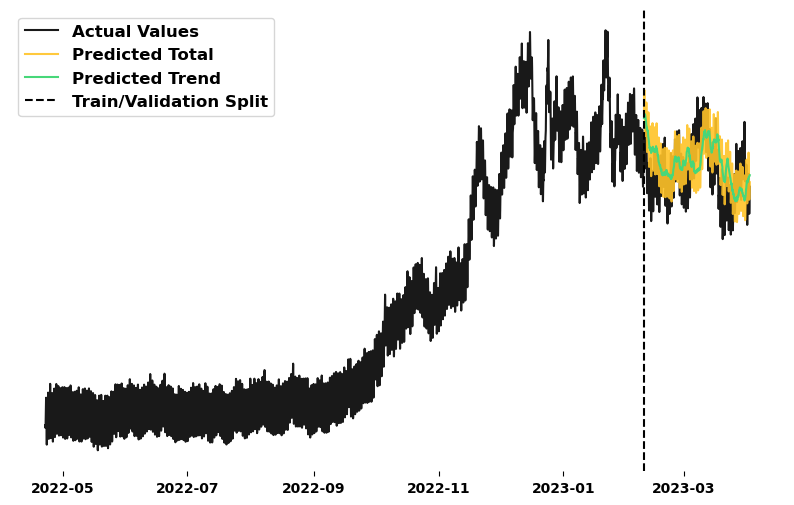

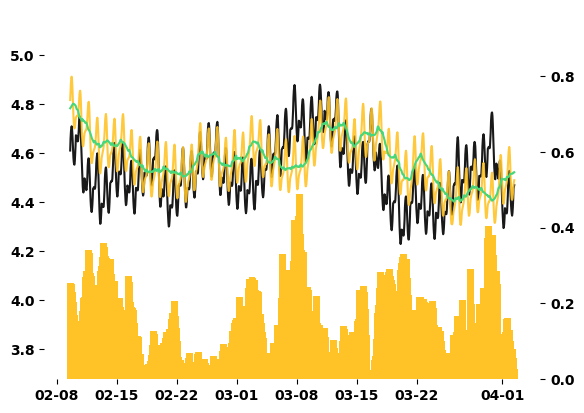

Error95: 0.047029448238484144
Out of sample MAPE: 2.251938869434271
Mean oveprediction: 2.475638175749951
Mean underprediction: 1.8465471401155829
MAPE with trend prediction only: 2.591401137025231
Coefficients: 
is_holiday: 0.004022628268866432
is_weekend: 0.013106068199855925
hour: -0.005482163783072857
month: 0.027891763058426312
temperature_trend: -0.02856533897176611
temperature_seasonal: -0.001129193175890896
spot_price_trend: -0.002350430182362641
spot_price_seasonal: 0.0014967031762641498
temperature_trend_L24: -0.015703602962578753
temperature_trend_L25: -0.01468877627077585
temperature_trend_L26: -0.013674044457477767
temperature_trend_L27: -0.012667842287956723
temperature_trend_L28: -0.01167583607094446
temperature_trend_L29: -0.010697953906824724
temperature_trend_L30: -0.009731406545613115
temperature_trend_L31: 0.029949918216170723
temperature_trend_L32: -0.007827626531621024
temperature_trend_L33: -0.006892950101601105
temperature_trend_L34: -0.005977810858176801
temper

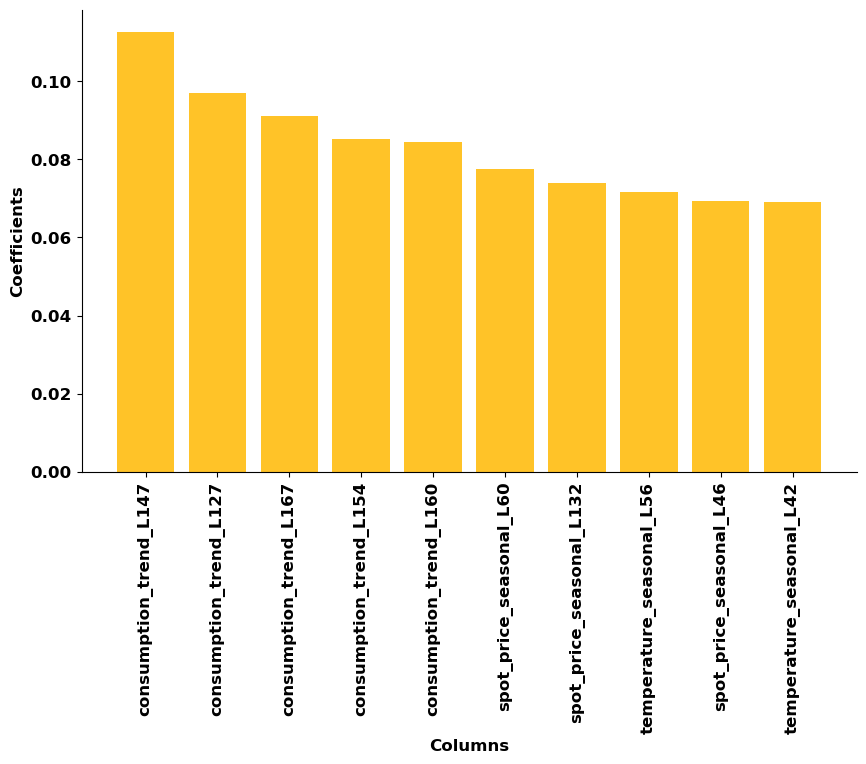

Trondheim
Alpha1, alpha2, MAPEfac, initVarianceFac --> MAPE
3.814697265625e-06 0.0009765625 10 50 --> 1.1702058917151839
3.814697265625e-06 0.0009765625 10 75 --> 1.0041842505289575
3.814697265625e-06 0.00390625 10 50 --> 1.135260357095202
3.814697265625e-06 0.00390625 10 75 --> 1.0432667230835526
1.52587890625e-05 0.0009765625 10 50 --> 1.1924277190112427
1.52587890625e-05 0.0009765625 10 75 --> 1.1526980688607413
1.52587890625e-05 0.00390625 10 50 --> 1.2317754343961087
1.52587890625e-05 0.00390625 10 75 --> 1.0534052823211595
Best Hyperparameters: (3.814697265625e-06, 0.0009765625, 10, 75)
Best CV MAPE: 1.0041842505289575%


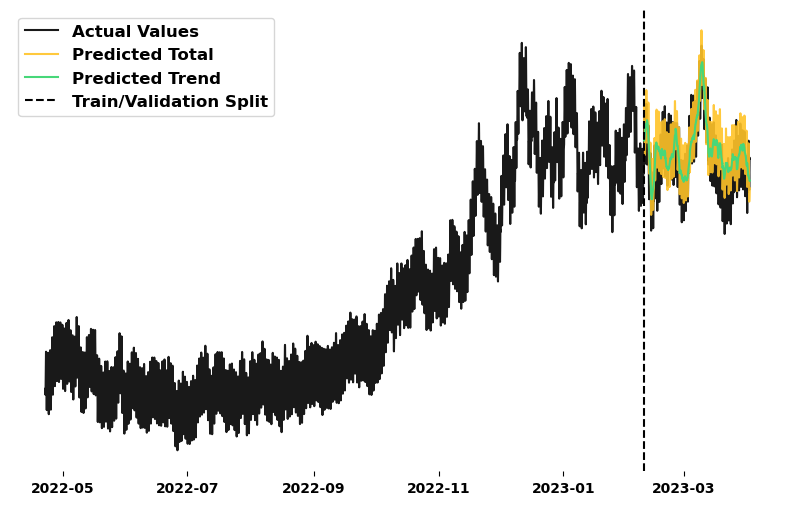

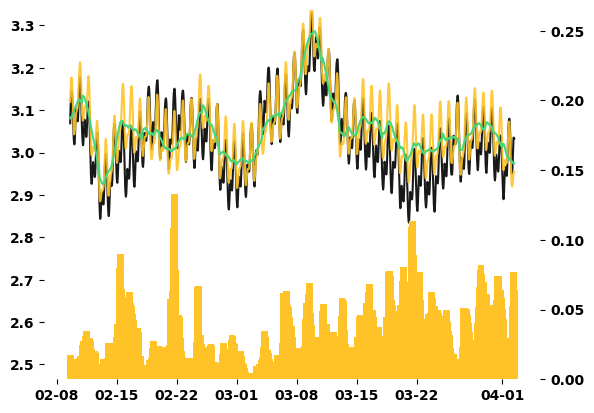

Error95: 0.030812241411467642
Out of sample MAPE: 1.3144619310771029
Mean oveprediction: 1.4789702846318493
Mean underprediction: 0.821465836179921
MAPE with trend prediction only: 1.8321913953581501
Coefficients: 
is_holiday: 0.0021744614551505916
is_weekend: 0.013740070692417871
hour: 0.002378664524127434
month: 0.0091032756340869
temperature_trend: -0.07613438394138486
temperature_seasonal: -0.00443702635500666
spot_price_trend: -0.0019538517099859194
spot_price_seasonal: 0.000850381835587343
temperature_trend_L24: -0.018286524448197818
temperature_trend_L25: 0.0030695448629298066
temperature_trend_L26: -0.013371252113924608
temperature_trend_L27: -0.011142329757382776
temperature_trend_L28: -0.00908466165658031
temperature_trend_L29: -0.00720491329550527
temperature_trend_L30: -0.0055051454760250106
temperature_trend_L31: -0.003989074967178855
temperature_trend_L32: -0.002661633974415546
temperature_trend_L33: -0.0015210311388999002
temperature_trend_L34: -0.0005645896320825172
tem

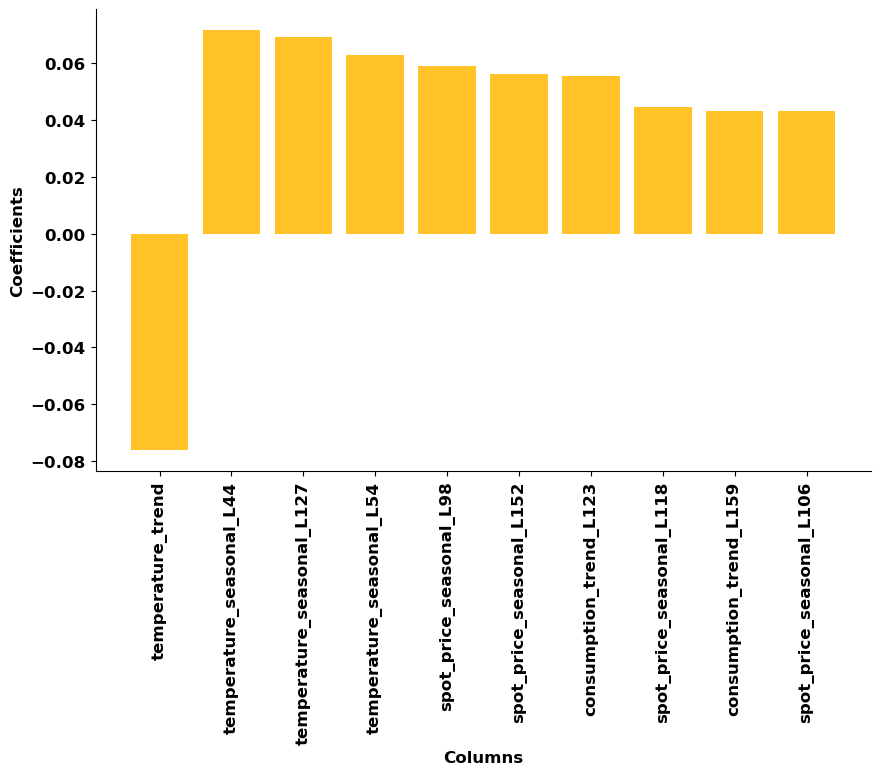

Tromsø
Alpha1, alpha2, MAPEfac, initVarianceFac --> MAPE
3.814697265625e-06 0.0009765625 10 50 --> 1.8064273450125046
3.814697265625e-06 0.0009765625 10 75 --> 1.7838905290716789
3.814697265625e-06 0.00390625 10 50 --> 1.8825459895680499
3.814697265625e-06 0.00390625 10 75 --> 1.6433378131322711
1.52587890625e-05 0.0009765625 10 50 --> 1.8786742495310207
1.52587890625e-05 0.0009765625 10 75 --> 1.6861306144995774
1.52587890625e-05 0.00390625 10 50 --> 1.6891422186634493
1.52587890625e-05 0.00390625 10 75 --> 1.9407509707922415
Best Hyperparameters: (3.814697265625e-06, 0.00390625, 10, 75)
Best CV MAPE: 1.6433378131322711%


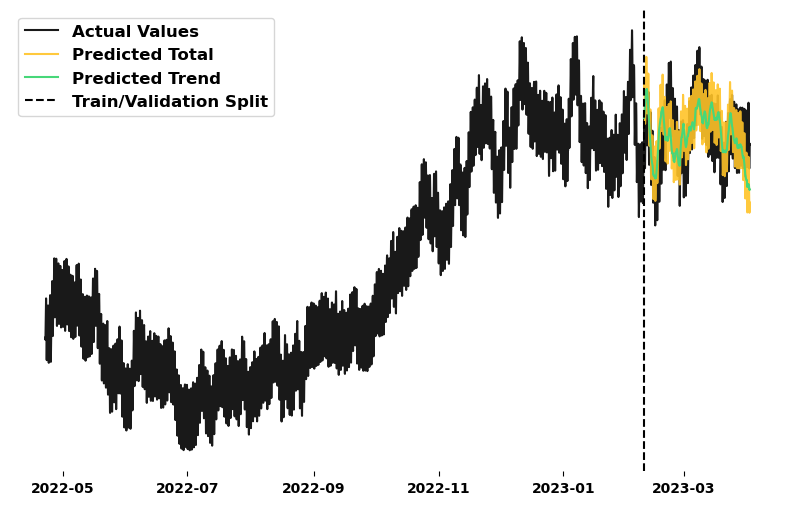

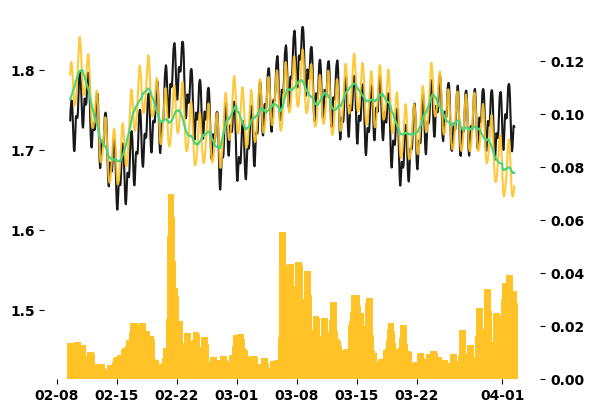

Error95: 0.035645649801734534
Out of sample MAPE: 1.4913090301426195
Mean oveprediction: 1.5094932049032541
Mean underprediction: 1.4703200173339837
MAPE with trend prediction only: 1.7841977610596824
Coefficients: 
is_holiday: 0.008881298643247267
is_weekend: 0.001487680782559981
hour: 0.0007016143643873044
month: 0.012717949785988218
temperature_trend: -0.030751455829396382
temperature_seasonal: 3.9085693156324205e-05
spot_price_trend: 0.004636069700032788
spot_price_seasonal: 0.00036514387732487937
temperature_trend_L24: -0.007472666930595045
temperature_trend_L25: -0.0065261435709742825
temperature_trend_L26: -0.005625630828817344
temperature_trend_L27: -0.004775654982543391
temperature_trend_L28: -0.003980506911514886
temperature_trend_L29: -0.0032423284255657893
temperature_trend_L30: -0.0025627576352875037
temperature_trend_L31: -0.0019422508222745785
temperature_trend_L32: -0.0013806165122025654
temperature_trend_L33: -0.0008787861185741385
temperature_trend_L34: -0.00043748508

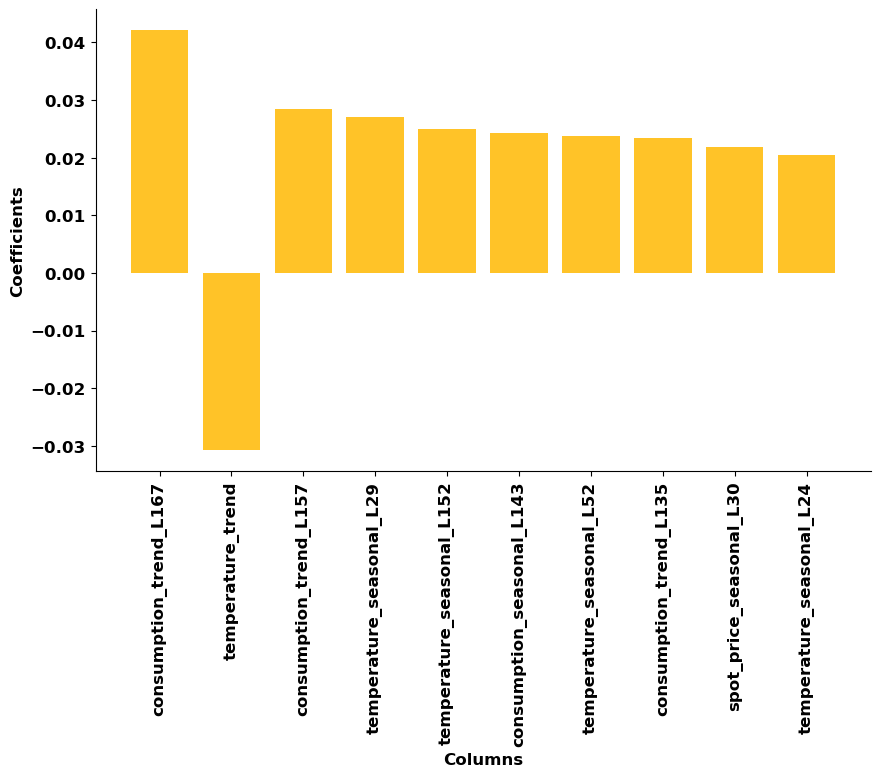

Bergen
Alpha1, alpha2, MAPEfac, initVarianceFac --> MAPE
3.814697265625e-06 0.0009765625 10 50 --> 1.560344716728979
3.814697265625e-06 0.0009765625 10 75 --> 1.0607731162943068
3.814697265625e-06 0.00390625 10 50 --> 1.4335777923486628
3.814697265625e-06 0.00390625 10 75 --> 1.476990772433301
1.52587890625e-05 0.0009765625 10 50 --> 1.7179993793179247
1.52587890625e-05 0.0009765625 10 75 --> 1.3817558741493492
1.52587890625e-05 0.00390625 10 50 --> 1.6437444427795787
1.52587890625e-05 0.00390625 10 75 --> 1.4832579766899385
Best Hyperparameters: (3.814697265625e-06, 0.0009765625, 10, 75)
Best CV MAPE: 1.0607731162943068%


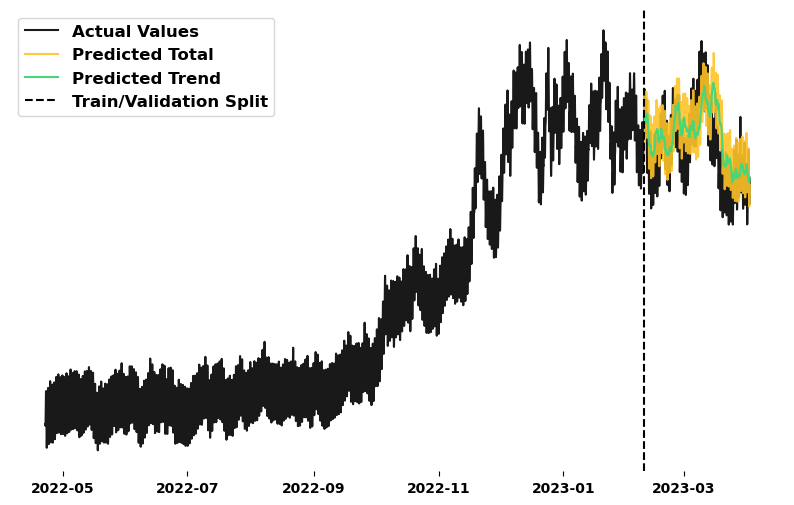

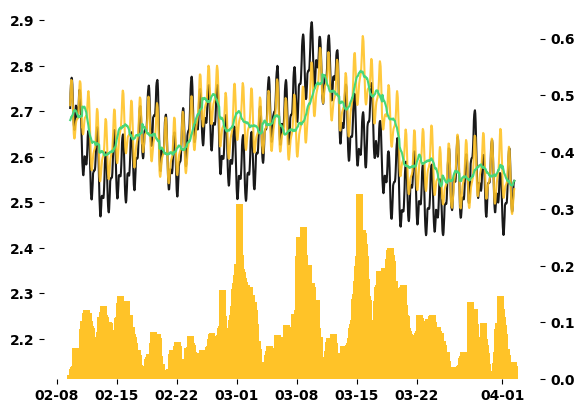

Error95: 0.05031251972890017
Out of sample MAPE: 2.1343513147311266
Mean oveprediction: 2.4631192154592516
Mean underprediction: 1.3905247256821929
MAPE with trend prediction only: 2.584072000701886
Coefficients: 
is_holiday: 0.00692940021967935
is_weekend: 0.019196231976133935
hour: 0.01773578462533248
month: 0.011206608490922355
temperature_trend: -0.031606283741187846
temperature_seasonal: -0.0012035638718825442
spot_price_trend: -0.0032802445421108123
spot_price_seasonal: 0.0005914963657701472
temperature_trend_L24: -0.010926257974127369
temperature_trend_L25: -0.009859828953818539
temperature_trend_L26: 0.0033427027813394796
temperature_trend_L27: -0.007904491498499736
temperature_trend_L28: -0.007028296535177775
temperature_trend_L29: -0.006223594317799851
temperature_trend_L30: -0.005494826713041388
temperature_trend_L31: -0.004843051479963137
temperature_trend_L32: 0.007557589252276057
temperature_trend_L33: -0.003751576947754907
temperature_trend_L34: -0.003299087268098736
tem

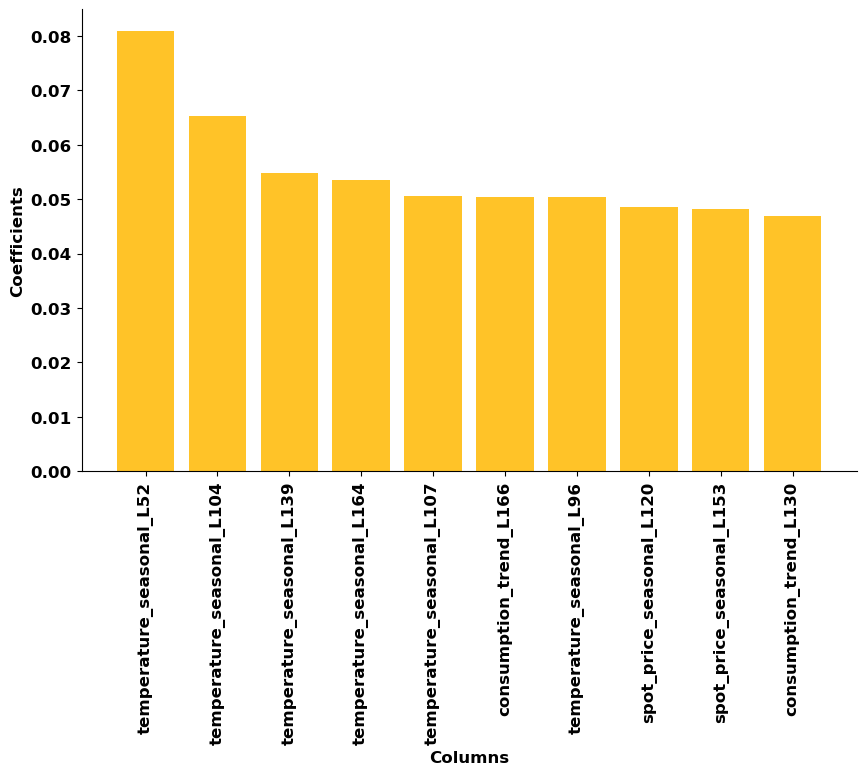

In [222]:
all_models = []
for I in range(5):
    data=DFS[I]
    print(DF_STRINGS[I])
    mu, sig = REVERSE_CONSUMPTION_NORMALIZATION[I]

    #alpha1s = [2**(-20),2**(-18)]
    #alpha2s = [2**(-12), 2**(-11), 2**(-10)]
    #MAPEfacs = [0.1, 1, 10, 100]
    alpha1s = [2**(-18), 2**(-16)]
    alpha2s = [2**(-10), 2**(-8)]
    MAPEfacs = [10]
    initVarianceFacs = [50,75]

    # Grid Search
    best_mape = float('inf')
    best_hyperparams = None

    print("Alpha1, alpha2, MAPEfac, initVarianceFac --> MAPE")
    for alpha1 in alpha1s:
        for alpha2 in alpha2s:
            for MAPEfac in MAPEfacs:
                for initVarianceFac in initVarianceFacs:
                    average_mape = cross_validate(data,alpha1,alpha2,mu,sig,MAPEfac,initVarianceFac)
                    print(f"{alpha1} {alpha2} {MAPEfac} {initVarianceFac} --> {average_mape}")
                    # Update best hyperparameters if current MAPE is lower
                    if average_mape < best_mape:
                        best_mape = average_mape
                        best_hyperparams = (alpha1,alpha2,MAPEfac,initVarianceFac)

    print(f'Best Hyperparameters: {best_hyperparams}')
    print(f'Best CV MAPE: {best_mape}%')

    tol = 1e-4
    X = data
    y1 = X["consumption_seasonal"]
    y2 = X["consumption_trend"]
    X = X.drop(columns=["consumption_seasonal", "consumption_trend"])

    X_train, X_val = custom_train_val_split(X, VAL_SPLIT)
    y1_train, y1_val = custom_train_val_split(y1, VAL_SPLIT)
    y2_train, y2_val = custom_train_val_split(y2, VAL_SPLIT)

    # Lasso with MAPE Loss
    def lasso_mape_loss(w, X, y_true, alpha):

        y_pred = X @ w
        return np.mean(soft_abs((y_true - y_pred)/(y_true+best_hyperparams[2]))) + alpha * np.sum(soft_abs(w))/np.mean(y_true+best_hyperparams[2])

    n_features = X_train.shape[1]
    w_optimal_1 = np.random.randn(n_features)/best_hyperparams[3] # Random initialize
    w_optimal_2 = np.random.randn(n_features)/best_hyperparams[3] # Random initialize
    for i in range(4):
        w_initial1 = np.where(w_optimal_1>10**(-2),w_optimal_1,0)+np.random.randn(n_features)/1000 # Set small coefficients to zero, add noise 
        w_initial2 = np.where(w_optimal_2>10**(-2),w_optimal_2,0)+np.random.randn(n_features)/1000 # Set small coefficients to zero, add noise 
        result = minimize(lasso_mape_loss, w_initial1, args=(X_train, y1_train, best_hyperparams[0]), method='L-BFGS-B', options={'tol':tol})
        w_optimal_1 = result.x
        result = minimize(lasso_mape_loss, w_initial2, args=(X_train, y2_train, best_hyperparams[1]), method='L-BFGS-B', options={'tol':tol})
        w_optimal_2 = result.x

    w_initial1 = np.where(w_optimal_1>10**(-2),w_optimal_1,0)
    w_initial2 = np.where(w_optimal_2>10**(-2),w_optimal_2,0)
    result = minimize(lasso_mape_loss, w_initial1, args=(X_train, y1_train, best_hyperparams[0]), method='L-BFGS-B')
    w_optimal_1 = result.x
    result = minimize(lasso_mape_loss, w_initial2, args=(X_train, y2_train, best_hyperparams[1]), method='L-BFGS-B')
    w_optimal_2 = result.x

    y1_pred = X_val @ w_optimal_1
    y2_pred = X_val @ w_optimal_2
    all_models.append([w_optimal_1, w_optimal_2])

    train_pred1 = X_train @ w_optimal_1
    train_pred2 = X_train @ w_optimal_2

    actual = (y1 + y2)
    full_preds = np.concatenate(((train_pred1 + train_pred2).T,(y1_pred + y2_pred).T)).T
    mu, sig = REVERSE_CONSUMPTION_NORMALIZATION[I]

    # Create an array of indices for plotting
    xs = X.index
    xs_train = X_train.index
    xs_oos = X_val.index

    # Plot actual values and predictions
    plt.figure(figsize=(10, 6))
    plt.plot(xs, (actual) * sig + mu, label='Actual Values', color='black', alpha=0.9)
    #plt.plot(xs_train, (train_pred1 + train_pred2) * sig + mu, label='In-sample predictions', color='#CFDDFF',alpha=0.9)
    plt.plot(xs_oos, (y1_pred + y2_pred) * sig + mu, label='Predicted Total', color='#FFC328', alpha=0.9)
    plt.plot(xs_oos, (y2_pred) * sig + mu, label='Predicted Trend', color='#47D779')
    plt.axvline(xs[len(train_pred1)], linestyle='--', color='black', label='Train/Validation Split')
    #plt.title(f"Lasso Predictions vs Actual Values - {DF_STRINGS[I]}")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    #plt.xlabel('Time')
    plt.xticks(fontweight='bold')
    plt.yticks([])
    #plt.ylabel('Values')
    plt.legend()
    legend = plt.legend(fontsize='12')
    for text in legend.get_texts():
        text.set_fontweight('bold')
    plt.show()

    ys = pd.DataFrame(y1_val+y2_val)
    temp = DFS_orig[I].merge(ys , how = "inner", right_index=True, left_index=True)
    monetary_exposure = np.abs((y1_val+y2_val - (y1_pred+y2_pred))*sig)*temp["spot_price"] 

    # Plot only oos values and predictions
    fig,ax1 = plt.subplots()
    ax1.plot(xs_oos, (y1_val+y2_val) * sig + mu, label='Actual Values', color='black', alpha=0.9)
    #plt.plot(xs_train, (train_pred1 + train_pred2) * sig + mu, label='In-sample predictions', color='#CFDDFF',alpha=0.9)
    ax1.plot(xs_oos, (y1_pred + y2_pred) * sig + mu, label='Predicted Total', color='#FFC328', alpha=0.9)
    ax1.plot(xs_oos, (y2_pred) * sig + mu, label='Predicted Trend', color='#47D779')
    date_format = mdates.DateFormatter('%m-%d')  # Format: Month-Day
    ax1.xaxis.set_major_formatter(date_format)

    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    ax1.set_ylim([min((y1_val+y2_val) * sig + mu)/1.15, max(actual * sig + mu)])
    ax2 = plt.gca().twinx()
    ax2.bar(xs_oos, monetary_exposure, color='#FFC328', label='Monetary Exposure')#.set_ylim([0, 2*max(monetary_exposure)])
    ax2.set_ylim([0,2*max(monetary_exposure)])
    plt.yticks(fontweight='bold')

    #plt.title(f"Lasso Predictions vs Actual Values - {DF_STRINGS[I]}")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    #plt.xlabel('Time')
    #plt.xticks(fontweight='bold')
    #plt.yticks(fontweight='bold')

    plt.show()

    resids = ((y1_val+y2_val)*sig - (y1_pred+y2_pred)*sig) / ((y1_val+y2_val)*sig+mu)
    oos_MAPE = np.mean(np.abs(resids)) * 100
    error_95 = np.percentile(np.abs(resids),95)
    print(f'Error95: {error_95}')
    mape_positive = resids[resids < 0].mean()*-100
    mape_negative = resids[resids > 0].mean()*100
    mape_trend = np.mean(np.abs(((y1_val+y2_val)*sig - (y2_pred)*sig) / ((y1_val+y2_val)*sig+mu)))*100
    print(f"Out of sample MAPE: {oos_MAPE}")
    print(f"Mean oveprediction: {mape_positive}")
    print(f"Mean underprediction: {mape_negative}")
    print(f"MAPE with trend prediction only: {mape_trend}")

    cols = X.columns
    coefs_total= (w_optimal_1+w_optimal_2)*sig
    print("Coefficients: ")
    for i in range(len(cols)):
        if np.abs(coefs_total[i])>0:
            print(f"{cols[i]}: {coefs_total[i]}")
    print(f"Number of features: {np.sum(np.where(np.abs(coefs_total)>10**(-3),1,0))}")

    combined_list = list(zip(cols, coefs_total))

    # Sorting by the absolute value of coefficients
    sorted_list = sorted(combined_list, key=lambda x: abs(x[1]), reverse=True)
    top_10 = sorted_list[:10]
    top_cols, top_coefs = zip(*top_10)
    plt.figure(figsize=(10, 6))
    plt.bar(top_cols, top_coefs, color='#FFC328')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)
    #plt.title(f"Top 10 Important Features by Coefficient - {DF_STRINGS[I]}")
    plt.xlabel('Columns', fontweight='bold', fontsize=12)
    plt.ylabel('Coefficients', fontweight='bold', fontsize=12)
    plt.xticks(rotation=90)  # Rotates the x-axis labels for better readability
    plt.xticks(fontweight='bold', fontsize=12)
    plt.yticks(fontweight='bold', fontsize=12)
    plt.show()


    